<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/SaleDataset_Costumers_Cluster_com_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SaleDataset  Costumers

## Exemplo de clustering com uso de K-means, agrupando diversos clientes de um distribuidor atacadista em várias categorias, são elas:

1. FRESH: annual spending (m.u.) on fresh products (Continuous);
2. MILK: annual spending (m.u.) on milk products (Continuous);
3. GROCERY: annual spending (m.u.)on grocery products (Continuous);
4. FROZEN: annual spending (m.u.)on frozen products (Continuous)
5. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7. CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
8. REGION: customers Region â€“ Lisbon, Porto or Other (Nominal)
Descriptive Statistics: 


Dataset: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

### Libs

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

In [ ]:
from sklearn import preprocessing
from sklearn import cluster

### Dataset

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### Exploratória

#### Distribuição das variáveis

Observe outliers principalmente em Delicassen, Frozen, Fresh...

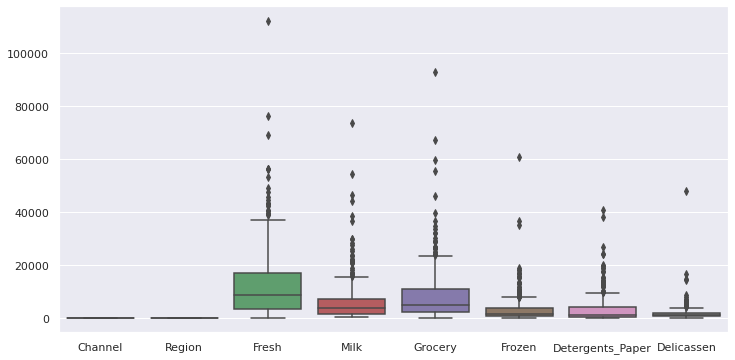

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df);
plt.show()

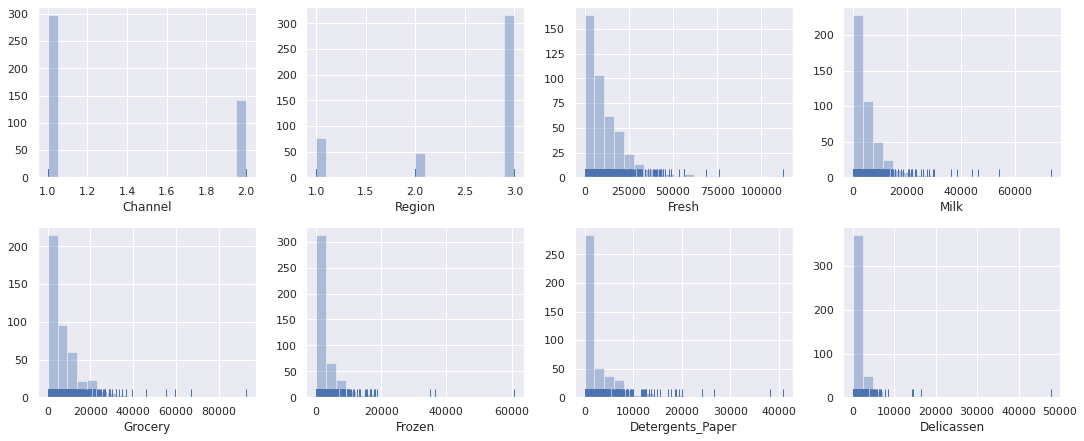

In [ ]:
plt.figure(figsize=(15, 18))

for i, col in enumerate(df.columns):
    plt.subplot(6, 4, i + 1)
    sns.distplot(df[col].dropna(), rug=True, kde=False, bins=20);
    # plt.title(col)

plt.tight_layout()

#### Normalizando features
Vamos padronizar os dados com z-score e retirar registros acimda de 3 desvios.

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(df)
X = scaler.transform(df)

In [ ]:
pd.DataFrame(X, columns=df.columns).head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,1.448652,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,1.448652,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293


In [ ]:
df_clean = df[(X < 3).all(axis=1)]
print(f"dataset sem outliers (retirados aqueles com z-score maior que 3: {len(df_clean)}")

dataset sem outliers (retirados aqueles com z-score maior que 3: 414


Agora vamos normalizar o novo dataset. 

Dessa forma, estamos nos previnindo que determinada feature domine as demais.


In [ ]:
mmscaler = preprocessing.MinMaxScaler()
mmscaler.fit(df_clean)
X_norm = mmscaler.transform(df_clean)
pd.DataFrame(X_norm, columns=df.columns).head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.258174,0.372031,0.217253,0.011187,0.156044,0.170259
1,1.0,1.0,0.143783,0.377998,0.274943,0.102818,0.192207,0.226119
2,1.0,1.0,0.129433,0.339172,0.220788,0.140878,0.205235,1.000000


### Encontrando o número ótimo de clusters
#### Elbow method

Na medida em que se aumenta o número de clusters as diferenças entre eles diminuem e as pontos intra-cluster aumentam. A fim de encontrar o K que tenha o melhor balanceamento, utiliza-se o método elbow (cotovelo): plota o resultado das somas dos quadrados dos clusters para vários K.

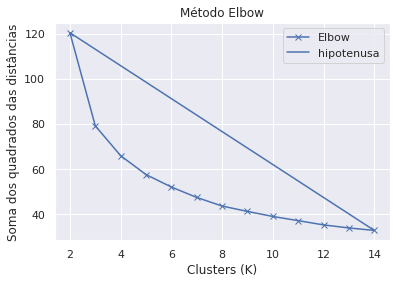

In [ ]:
# Arbitrarily selecting a range of values for K
K = range(2,15)

dist = []

# Using Scikit Learn’s KMeans Algorithm to find sum of squared distances
for k in K:
  model = cluster.KMeans(n_clusters=k).fit(X_norm)
  dist.append(model.inertia_)

# plt.plot(sum_of_squared_distances[0], sum_of_squared_distances[-1])
plt.plot(K, dist, 'bx-')

# hipotenusa
plt.plot([14, 2], [dist[-1],dist[0]])

plt.xlabel('Clusters (K)')
plt.ylabel('Soma dos quadrados das distâncias')
plt.title('Método Elbow')
plt.legend(['Elbow', 'hipotenusa'])
plt.show()

Intuitivamente, procura-se o número situado no cotovelo da reta, o que nos traria o número 4. Matemáticamente seria o ponto mais distante da curva - a hipotenusa da curva.

Faremos esse calculamos a seguir, e encontramos o mesmo valor.

In [ ]:
x1, y1 = 2, dist[0]
x2, y2 = 14, dist[len(dist)-1]

distances = []
for i in range(len(dist)):
    x0 = i + 2
    y0 = dist[i]

    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)

n_clusters = distances.index(max(distances)) + 2
print(n_clusters)

5


### Utilizando K-means para clusterização

#### Gerando clusters

In [ ]:
 kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(X_norm)
 y_kmeans = kmeans.predict(X_norm)

Distribuição dos clusters

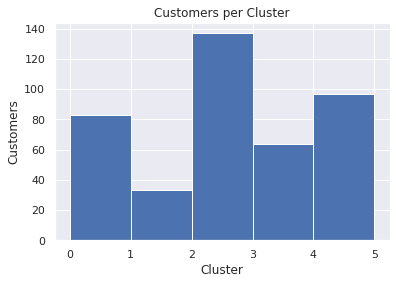

In [ ]:
plt.hist(y_kmeans, bins=range(n_clusters + 1))
plt.title ('Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
plt.show()

In [ ]:
df_cluster = pd.concat(
    [pd.DataFrame(X_norm, columns=df.columns),
    pd.DataFrame(y_kmeans, columns=['k_means'])],
    axis=1
)

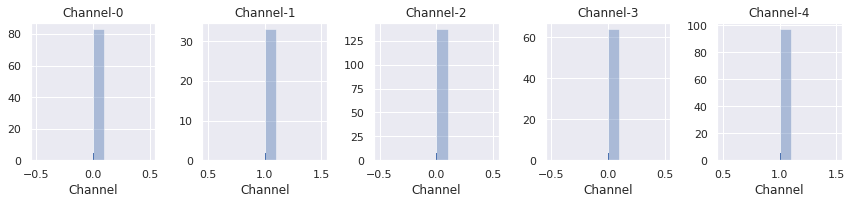

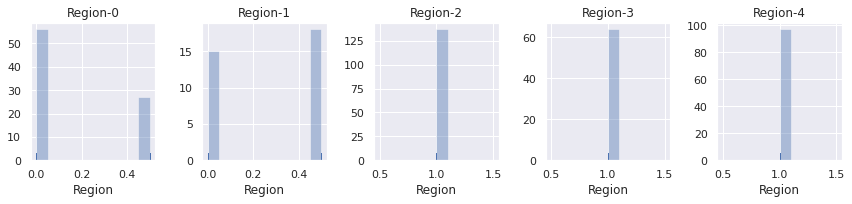

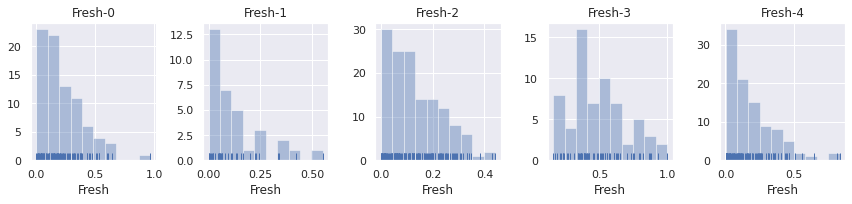

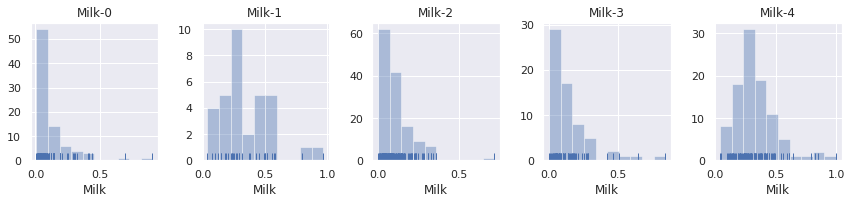

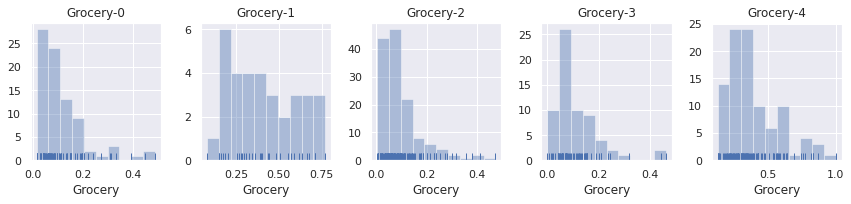

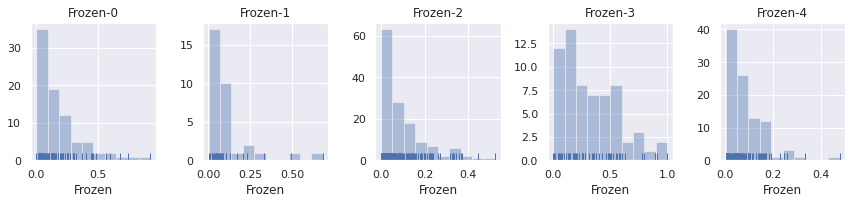

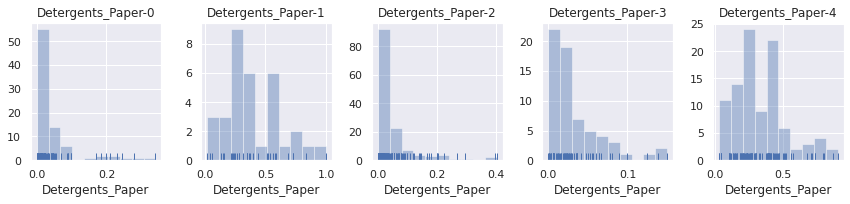

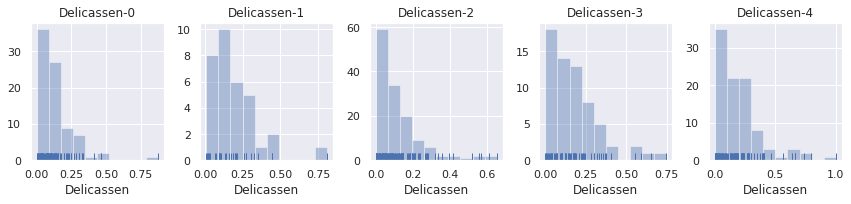

In [ ]:
for col in df.columns:
  cor = cores()
  plt.figure(figsize=(12,3))

  for i in range(n_clusters):
      plt.subplot(1, n_clusters, i + 1)
      cluster = df_cluster.query("k_means == @i")
      sns.distplot(cluster[col], rug=True, bins=10, kde=False);
      plt.title('{}-{}'.format(col, i))
      
  plt.tight_layout()
  plt.show()

Conclusões:

Grupos:

grp 0. Mais forte na região de Lisboa para hoteis e restaurantes. Possui maiores gastos em produtos frescos.

grp 1. Atua em todas as regiões para varejo. Gastos maiores em mercadinhos e detergentes. 

grp 2. Grupo 2, o cluster com maiores usuários tem predominância em produtos frescos na região do Porto.

grp 3. Produtos frescos e congelados. Hoteis e restaurantes na região do Porto.

grp 4. Comportamento parecido com o grupo 2, apesar de ter maior distribuição